In [1]:
from typing import Sequence, Tuple, List
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import cirq
from ansatz import CylicQAOAAnsatz
from maxcut import edge_operator, maxcut_hamiltonian, bitstring_energy

## Maximize the subgraph expectation value (QAOA Eqn. 24).

In [14]:
def func_max(p, gamma, beta) -> float:
    """Maximize the function given the starting values of gamma and beta."""

    qs = cirq.LineQubit.range(2 * p + 2)
    bitstring = [True] * len(qs)
    qubit_graph = nx.Graph()
    for i in range(len(qs) - 1):
        qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
    #hamiltonian = maxcut_hamiltonian(qubit_graph)
    observable = -1.0 * edge_operator(qs[p], qs[p+1])
    qaoa_ansatz = CylicQAOAAnsatz(qubit_graph, observable)

    def objective_callback(vars: np.ndarray):
        assert vars.size % 2 == 0
        
        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        return qaoa_ansatz.energy(gammas, betas)

    def gradient_callback(vars:np.ndarray):
        assert vars.size % 2 == 0

        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        gamma_grad, beta_grad = qaoa_ansatz.energy_grad(gammas, betas)
        return np.concatenate((gamma_grad, beta_grad))

    vars0 = np.concatenate((gamma, beta))
    #print(gamma.shape, beta.shape, vars0.shape)
    opt_result = minimize(objective_callback, vars0, method="Powell")
    assert opt_result.success, f"Optimizer failed: {opt_result.message}"
    return objective_callback(opt_result.x)


def func_max_random_starts(p, repetitions) -> float:
    """Maximize the function with different sets of starting parameters.
    Returns only the best one."""

    gammas = np.random.rand(repetitions, p)
    betas = np.random.rand(repetitions, p)
    f_maxs = []
    for i in range(repetitions):
        f_maxs.append(func_max(p, gammas[i, :], betas[i, :]))
    return np.min(f_maxs) # The minimum is the best one because we are maximizing, so we use -H.


ps = range(1, 6)
f_max = []
for p in ps:
    print(f"p = {p}")

    # Optimize the expectation value using Scipy's optimizer.
    gammas = np.random.rand(p)
    betas = np.random.rand(p)
    f_max.append(func_max_random_starts(p, 10))

df = pd.DataFrame({"p": ps, "f_max": f_max})
df.set_index("p", inplace=True)
print(df.head())

p = 1
p = 2
p = 3
p = 4
p = 5
      f_max
p          
1 -0.749999
2 -0.833304
3 -0.874787
4 -0.899941
5 -0.905015


In [15]:
df.to_csv("cycle_maxima.csv")

In [16]:
def exact_f_max(p):
    """See section 4 of QAOA paper."""

    return (2 * p + 1) / (2 * p + 2)

exact_maxima = np.array([exact_f_max(p) for p in ps])

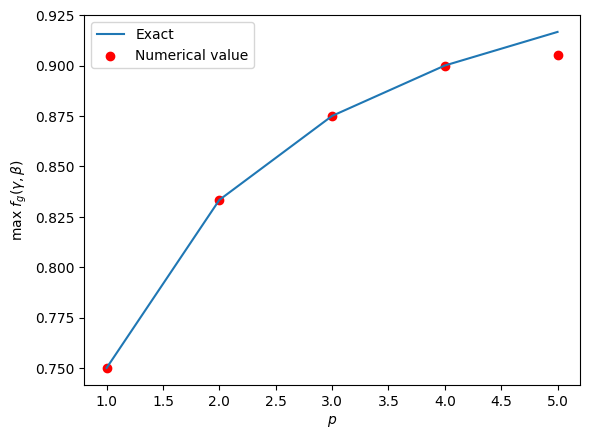

In [17]:
fig, ax = plt.subplots()
ax.plot(ps, exact_maxima, '-', label="Exact")
ax.scatter(ps, -1.0 * np.array(f_max), c="red", label="Numerical value")
ax.set_xlabel(r"$p$")
ax.set_ylabel(r"max $f_g(\gamma, \beta)$")
plt.legend()
plt.savefig("maxima.pdf")

## Approximation ratio for the cycle graph.

In [3]:
def approximation_ratio_fixed_start(n: int, gamma: np.ndarray, beta: np.ndarray) -> float:
    """Get the approximation ratio for given starting values of gamma and beta."""

    assert gamma.size == beta.size

    # Define a cycle graph for the MaxCut problem.
    qs = cirq.LineQubit.range(n)
    qubit_graph = nx.Graph()
    for i in range(len(qs)):
        qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
    hamiltonian = maxcut_hamiltonian(qubit_graph)
    ansatz = CylicQAOAAnsatz(qubit_graph, hamiltonian)

    # Optimize the energy numerically.
    def objective_callback(vars: np.ndarray):
        assert vars.size % 2 == 0
        
        gammas = vars[:(vars.size // 2)]
        betas = vars[(vars.size // 2):]
        return ansatz.energy(gammas, betas)
    
    vars0 = np.concatenate((gamma, beta))
    opt_result = minimize(objective_callback, vars0, method="Powell", options={"maxiter": 1_000_000})
    assert opt_result.success, f"Optimizer failed: {opt_result.message}"
    optimized_energy =  objective_callback(opt_result.x)
    gamma_opt = opt_result.x[:gamma.size]
    beta_opt = opt_result.x[gamma.size:]

    # Sample bitstrings from the circuit with optimal parameters, and get their energies.
    bitstrings = ansatz.sample_bitstrings(gamma_opt, beta_opt, 1_000)
    sampled_energies = [bitstring_energy(bitstrings[i, :], hamiltonian) for i in range(bitstrings.shape[0])]

    # Return the ratio of the optimized and ideal energies. 
    if n % 2 == 0:
        ideal_energy = n
    else:
        ideal_energy = n - 1
    #return -optimized_energy / ideal_energy
    return -np.min(sampled_energies) / ideal_energy


def approximation_ratio_random_starts(n: int, p: int, trials: int) -> float:
    """Get the maximum of the approximation ratio, starting from different gammas and betas."""

    gammas = np.random.rand(trials, p)
    betas = np.random.rand(trials, p)
    all_approximation_ratios = []
    for i in range(n):
        all_approximation_ratios.append(approximation_ratio_fixed_start(n, gammas[i, :], betas[i, :]))
    return np.max(all_approximation_ratios)

n = 5
for p in range(5):
    gamma0 = np.random.rand(p)
    beta0 = np.random.rand(p)
    approx = approximation_ratio_random_starts(n, p, 10)
    print(f"p = {p}, Approximation ratio: {approx}")

p = 0, Approximation ratio: 1.0
p = 1, Approximation ratio: 1.0
p = 2, Approximation ratio: 1.0
p = 3, Approximation ratio: 1.0
p = 4, Approximation ratio: 1.0
